In [3]:
from __future__ import absolute_import, division, print_function

import sys
import os
import time
import pickle
from math import ceil, floor, sqrt

sys.path.insert(0,'../../')
sys.path.insert(0,'../../../py')

import parameters
import utilities
import output_utilities
from spectrogram_utilities import spectrogram_plot, spectrogram_reshape, spectrogram_hist
from spectrogram_output_visualiser import spectrogram_and_output, spectrogram_cut, spectrogram_cut_augmented
import spectrogram_cuts_db_creation


import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import load_model

# matplotlib.get_backend()
%matplotlib inline

# constants
awd_event = 1
site = parameters.sites[0]

# use gpu
from keras import backend as K
print('GPUs:',K.tensorflow_backend._get_available_gpus())
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))


GPUs: ['/job:localhost/replica:0/task:0/device:GPU:0']


Using TensorFlow backend.


In [4]:
def spectrogram_split(spectrogram, width, height):
    '''Split the spectrogram according to width and height'''
    # mark the cut in the spectrogram
    spec = spectrogram.copy()
    f_max, t_max = spec.shape
    t_index = np.array(list(range(0, t_max, ceil(t_max/width))))
    f_index = np.array(list(range(0, f_max, ceil(f_max/heigth))))
    for t in t_index:
        spec[:,t] = np.full(spec[:,0].shape, spec.min())
    for f in f_index:
        spec[f,:] = np.full(spec[0,:].shape, spec.min())
    # extract the cuts
    cuts = []
    indices = []
    for f in range(len(f_index)):
        for t in range(len(t_index)):
            if t < len(t_index)-1 and f<len(f_index)-1:
                cuts.append(spectrogram_reshape(spectrogram[f_index[f]:f_index[f+1],t_index[t]:t_index[t+1]]))
                indices.append([t_index[t],t_index[t+1],f_index[f],f_index[f+1]])
            elif f == len(f_index)-1 and t < len(t_index)-1:
                cuts.append(spectrogram_reshape(spectrogram[f_index[f]:f_max,t_index[t]:t_index[t+1]]))
                indices.append([t_index[t],t_index[t+1],f_index[f],f_max])
            elif t==len(t_index)-1 and f < len(f_index)-1:
                cuts.append(spectrogram_reshape(spectrogram[f_index[f]:f_index[f+1],t_index[t]:t_max]))
                indices.append([t_index[t],t_max,f_index[f],f_index[f+1]])
            else:
                cuts.append(spectrogram_reshape(spectrogram[f_index[f]:f_max,t_index[t]:t_max]))
                indices.append([t_index[t],t_max,f_index[f],f_max])
    cuts = np.array(cuts)
    
    return spec, indices, cuts
        

In [5]:
# load scaler and cnn model
standard_scaler = pickle.load( open( "scaler.pickle", "rb" ) )
scaler = standard_scaler["scaler"]
model = load_model('cnn.h5')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 32, 128, 128)      320       
_________________________________________________________________
dropout_19 (Dropout)         (None, 32, 128, 128)      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 16, 128, 128)      4624      
_________________________________________________________________
dropout_20 (Dropout)         (None, 16, 128, 128)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 8, 128, 128)       1160      
_________________________________________________________________
max_pooling2d_7 (MaxP

SAMPLE: 2013-06-03UT16:32:39.88633094.marion.vr2
SPECTROGRAM OF SAMPLE:2013-06-03UT16:32:39.88633094.marion.vr2


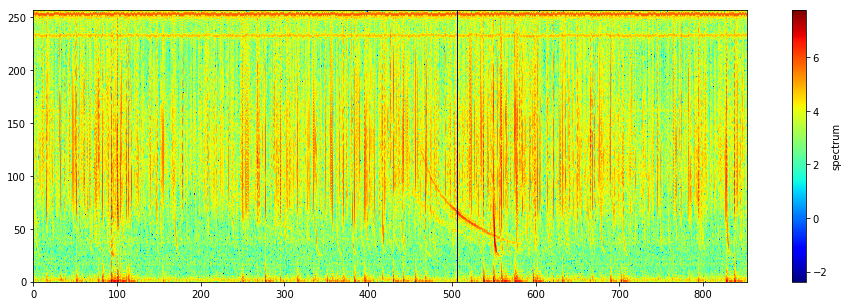

PRE-PROCESSED SAMPLE


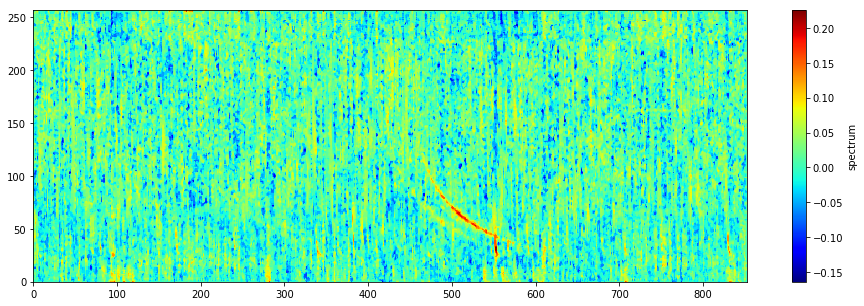

CUT USE FOR CLASSIFICATION


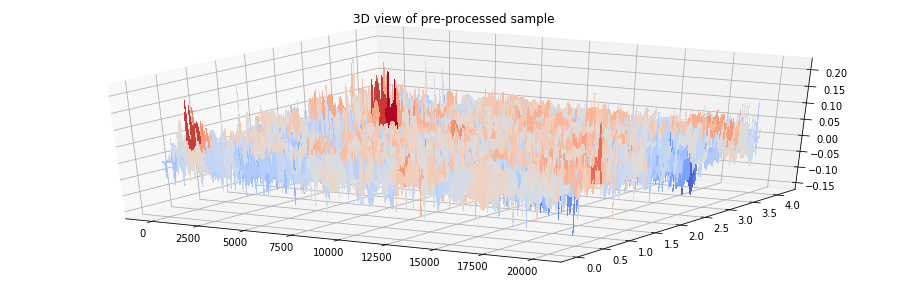

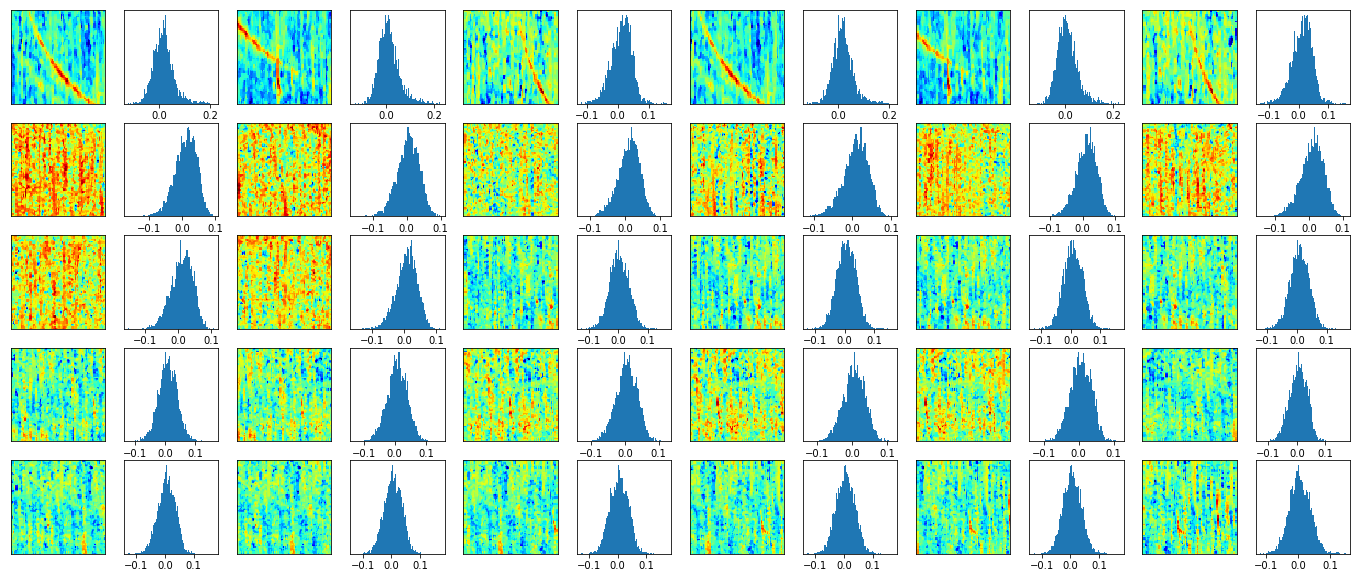

PRE-PROCESSED SAMPLE SHOWING CUT USED BY DETECTOR


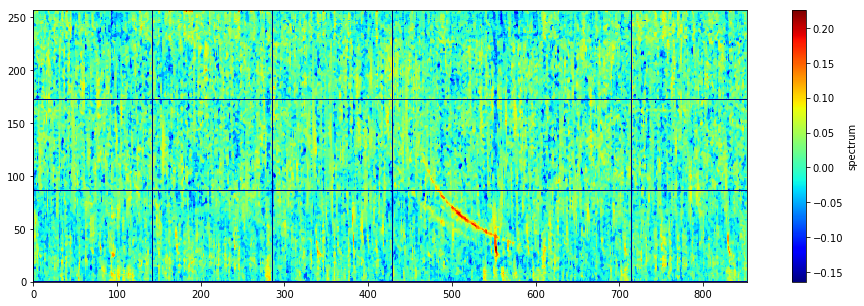

CLASSIFICATION OF CUTS USED BY DETECTOR


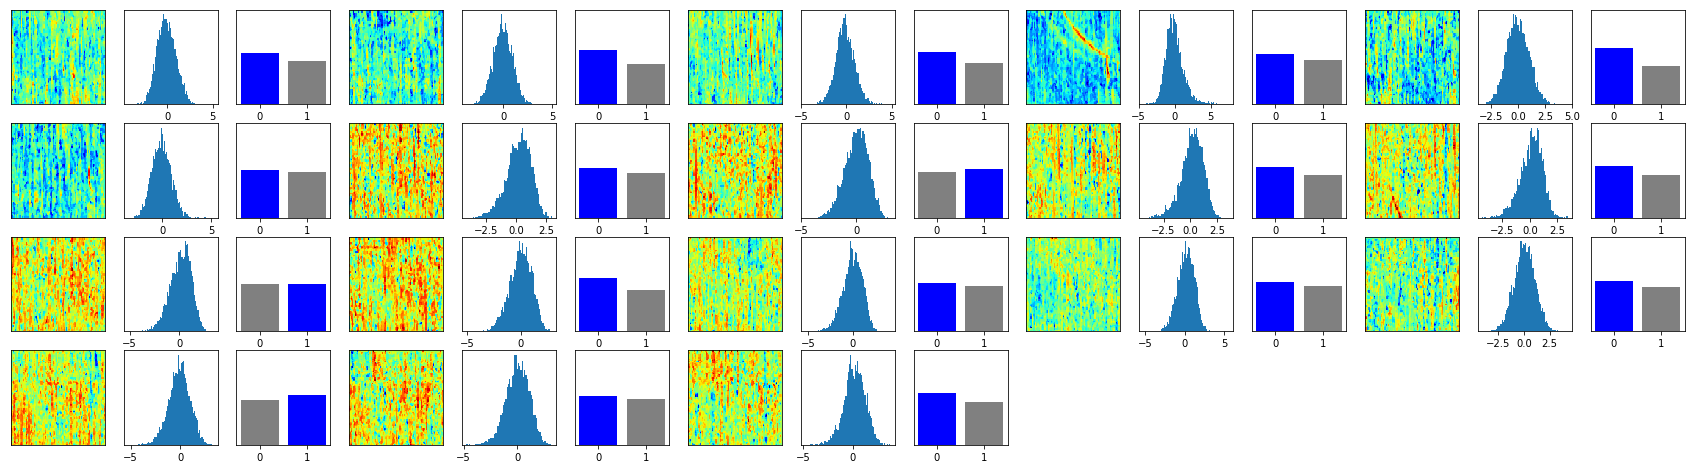

In [15]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from PIL import Image

# get file
site = parameters.sites[0]
file = utilities.random_file(awd_event, site)
# file = '2013-07-25UT05:24:35.84611922.marion.vr2'
file = '2013-06-03UT16:32:39.88633094.marion.vr2'
print("SAMPLE:",file)

# get spectrogram 
_, _, _, spectrogram_clean = spectrogram_and_output(awd_event, site, file, output=True, zscore=False)
_, time, freq, spectrogram_pro = spectrogram_and_output(awd_event, site, file, output=False, zscore=True, medfilt=True, method="normalize")
# # plot result with cut selection
width = 6
heigth = 3
print("SPECTROGRAM OF SAMPLE:"+file)
_ = spectrogram_plot(spectrogram_clean, size=(16,5))
# plt.pcolormesh(spec, cmap='jet')
print("PRE-PROCESSED SAMPLE")
_ = spectrogram_plot(spectrogram_pro, size=(16,5))

# plot 3D view
time, freq = np.meshgrid(time, freq)
fig = plt.figure(figsize=(16,5))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(freq, time, spectrogram_pro,cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.title("3D view of pre-processed sample")
# get classification cuts
indices, spectrogram, specs_cuts, noise_cuts, f_cut_length, t_cut_length = spectrogram_cut_augmented(
    awd_event, site, file, threshold=50, zscore=True, medfilt=True, method="normalize",output=False)
# plot cuts
cuts = specs_cuts.copy()
if len(noise_cuts):
    cuts = np.append(specs_cuts, noise_cuts, axis=0)
y_size = ceil(sqrt(len(cuts)))
x_size = ceil(len(cuts)/y_size)
print("CUT USE FOR CLASSIFICATION")
plt.figure(figsize=(y_size*2*2,x_size*2))
for i in range(0,len(cuts)*2,2):
    plt.subplot(x_size, y_size*2,i+1)
    index = int(i/2)
    spec = spectrogram[cuts[index][0]:cuts[index][1],cuts[index][2]:cuts[index][3]]
    spec = spectrogram_reshape(spec)
    spec = spec.reshape(1,parameters.clf_input_depth,parameters.clf_input_width,parameters.clf_input_height)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.pcolormesh(spec[0][0], cmap='jet')
#     plt.xlabel(np.argmax(pred, axis=1))
    plt.subplot(x_size, y_size*2, i+2)
    plt.yticks([])
    plt.hist(spec[0][0].flatten(), bins='auto')
plt.show()

# plot detector results
spec ,indices, detector_cuts = spectrogram_split(spectrogram_pro, width, heigth)
print("PRE-PROCESSED SAMPLE SHOWING CUT USED BY DETECTOR")
_ = spectrogram_plot(spec, size=(16,5))

y_size = ceil(sqrt(len(detector_cuts)))
x_size = ceil(len(detector_cuts)/y_size)
print("CLASSIFICATION OF CUTS USED BY DETECTOR")
plt.figure(figsize=(y_size*2*3,x_size*2))
for i in range(0,len(detector_cuts)*3,3):
    plt.subplot(x_size, y_size*3,i+1)
    index = int(i/3)
    spec = detector_cuts[index]
    spec = spectrogram_reshape(spec)
    spec = scaler.transform(spec.reshape(parameters.clf_input_depth,parameters.clf_input_width*parameters.clf_input_height))
    spec = spec.reshape(1,parameters.clf_input_depth,parameters.clf_input_width,parameters.clf_input_height)
    pred = model.predict(spec)[0]
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.pcolormesh(spec[0][0], cmap='jet')
    plt.subplot(x_size, y_size*3, i+2)
    plt.yticks([])
    plt.hist(spec[0][0].flatten(), bins='auto')
    plt.subplot(x_size, y_size*3, i+3)
    plt.yticks([])
    _range = np.arange(len(pred))
    plt.bar(_range[np.isin(pred, pred.min())], pred[np.isin(pred, pred.min())], color="gray")
    plt.bar(_range[np.isin(pred, pred.max())], pred[np.isin(pred, pred.max())], color="blue")
    plt.ylim([0, 1])
plt.show()